# Homework 2 - Introduction

The notebook is organized as follow:

* **Data Extraction**
* **Dataframes construction**
* **Dataset merging**
* **Analysis**
    1. **Homework question**
    2. **Exploratory analysis**

In [1]:
import requests as rq
import pandas as pd
import bs4
import re
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from itertools import product
from scipy.optimize import linear_sum_assignment
from nltk.metrics import edit_distance
from IPython.display import display, HTML

In [2]:
N = 200
M = 800 # If you want to run the code, you might want to use lower M (see later)

SITE1 = "https://www.topuniversities.com"
URL1 = SITE1+"/sites/default/files/qs-rankings-data/357051.txt"

SITE2 = "https://www.timeshighereducation.com"
URL2 = SITE2+"/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

# Data extraction

In [3]:
data1, data2 = (rq.get(URL).json().get("data") for URL in (URL1, URL2))

display(sorted(list(data1[0].keys())))
display(sorted(list(data2[0].keys())))

names1, names2 = ([u.get(key) for u in data[:M]] for data, key in ((data1, 'title'), (data2, 'name')))
print("Extracted %d and %d names" % (len(names1), len(names2)))

['cc',
 'core_id',
 'country',
 'guide',
 'logo',
 'nid',
 'rank_display',
 'region',
 'score',
 'stars',
 'title',
 'url']

['aliases',
 'location',
 'member_level',
 'name',
 'nid',
 'rank',
 'rank_order',
 'record_type',
 'scores_citations',
 'scores_citations_rank',
 'scores_industry_income',
 'scores_industry_income_rank',
 'scores_international_outlook',
 'scores_international_outlook_rank',
 'scores_overall',
 'scores_overall_rank',
 'scores_research',
 'scores_research_rank',
 'scores_teaching',
 'scores_teaching_rank',
 'stats_female_male_ratio',
 'stats_number_students',
 'stats_pc_intl_students',
 'stats_student_staff_ratio',
 'subjects_offered',
 'url']

Extracted 800 and 800 names


We start by fetching all the requested data from both websites. For the first URL (topuniversities), we have to request the data from each university page.

In [4]:
s = rq.Session()
reqs = [(req_id, s.prepare_request(rq.Request('GET', SITE1+entry["url"]))) for req_id, entry in enumerate(data1[:N])]
print(len(reqs), "requests to be sent.")

resps = [(req_id, s.send(req)) for req_id, req in reqs]

done = [(req_id, resp.text) for req_id, resp in resps if resp.status_code == 200]
failed = [(req_id, resp) for req_id, resp in resps if resp.status_code != 200]

print("%d done, %d failed." % (len(done), len(failed)))

non_digit = re.compile('[^0-9]')

class_to_labels = {"total+faculty": "fac_c_total",
                   "inter+faculty": "fac_c_inter",
                  "total+student":"stu_c_total",
                  "total+inter":"stu_c_inter"}


def resp_to_counts(req):
    req_id, resp = req
    page = bs4.BeautifulSoup(resp, "html.parser")
    top = page.body.find("div", class_="view-academic-data-profile")
    numdivs = top.find_all("div", class_="number")
    
    def get_label(div):
        if div == top:
            return None
        label = class_to_labels.get("+".join(div.get("class")))
        return label or get_label(div.parent)
    
    fac_counts = {(get_label(div), int(re.sub(non_digit,'', div.string))) for div in numdivs}
    return req_id, fac_counts

print("Parsing responses using up to %d threads..." % mp.cpu_count(), end="") 
with mp.Pool(mp.cpu_count()) as p:
    for req_id, counts in p.map(resp_to_counts, done):
        data1[req_id].update(counts)
print("done")

200 requests to be sent.
200 done, 0 failed.
Parsing responses using up to 8 threads...done


# Dataframes construction

We turn the raw JSON data into a actual pandas Dataframe object. Notice that we instead of the "student to staff" ratio, we prefer to compute the "staff to student" ratio so that we only work in a "the higher the better" mindset.

In [19]:
basecol = ["title", "rank_display", "country", "region"]
addedcol = ["fac_c_inter", "fac_c_total", "stu_c_inter", "stu_c_total"]

uni_s1 = pd.DataFrame(data1[:N], columns= basecol+addedcol)
uni_s1.rename(columns={"title":"name", "rank_display": "rank"},inplace=True)
# Convert the rank to a numerical type
uni_s1["rank"] = uni_s1["rank"].str.extract('(\d+)', expand=False).astype(int)

#ratio computations for s1 only because they are already available for s2
uni_s1['staff_student_ratio'] = uni_s1.apply(lambda row: row.fac_c_total/row.stu_c_total, axis=1)
uni_s1['pc_intl_students'] = uni_s1.apply(lambda row: (row.stu_c_inter/row.stu_c_total), axis=1)
uni_s1['pc_intl_staff'] = uni_s1.apply(lambda row: (row.fac_c_inter/row.fac_c_total), axis=1)

uni_s1.head()

,name,rank,country,region,fac_c_inter,fac_c_total,stu_c_inter,stu_c_total,staff_student_ratio,pc_intl_students,pc_intl_staff
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679.0,2982.0,3717.0,11067.0,0.269450,0.335863,0.563045
1,Stanford University,2,United States,North America,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422,0.476546
2,Harvard University,3,United States,North America,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785,0.301379
3,California Institute of Technology (Caltech),4,United States,North America,350.0,953.0,647.0,2255.0,0.422616,0.286918,0.367261
4,University of Cambridge,5,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899,0.414936


The second dataset already provide the ratios, we just have to invert the ```staff_student_ratio``` into a ```student_staff_ratio```.

In [6]:
basecol = ["name", "rank", "location", "stats_pc_intl_students", "stats_student_staff_ratio"]

uni_s2 = pd.DataFrame(data2[:N], columns=basecol)
uni_s2.rename(columns={"location":"country","stats_pc_intl_students":"pc_intl_students", "stats_student_staff_ratio":"student_staff_ratio"},inplace=True)

uni_s2["rank"] = uni_s2["rank"].str.extract('(\d+)', expand=False).astype(int)

uni_s2["pc_intl_students"]= uni_s2["pc_intl_students"].str.extract('(\d+)', expand=False).astype(float) / 100

#transforming of the ratios for s2 so that they are comparable with the data for s1
uni_s2['staff_student_ratio'] = uni_s2.apply(lambda row: 1/float(row.student_staff_ratio), axis=1)

uni_s2.head()

,name,rank,country,pc_intl_students,student_staff_ratio,staff_student_ratio
0,University of Oxford,1,United Kingdom,0.38,11.2,0.089286
1,University of Cambridge,2,United Kingdom,0.35,10.9,0.091743
2,California Institute of Technology,3,United States,0.27,6.5,0.153846
3,Stanford University,3,United States,0.22,7.5,0.133333
4,Massachusetts Institute of Technology,5,United States,0.34,8.7,0.114943


# Datasets merging

We compute the best matchings for university names by creating the matrix of the costs (using edit_distance as a cost function) of all the possible assignments. We then use this matrix to solve the linear sum assignment problem (The linear sum assignment problem is also known as minimum weight matching in bipartite graphs.

In [7]:
def col(name):
    return np.array([edit_distance(name, n) for n in names2])

p = mp.Pool(mp.cpu_count())
print("Computing cost matrix using %d workers..." % mp.cpu_count(), end="")

costs = np.array(p.map(col, names1))
print("done")

print("Computing optimal assigment...", end="")
id_n1, id_n2 = linear_sum_assignment(costs)
sol_costs = costs[id_n1[:N], id_n2[:N]]
print("Done: cost of solution = %d" % sol_costs.sum())


Computing cost matrix using 8 workers...done
Computing optimal assigment...Done: cost of solution = 822


This method will find an assignment in any case, which means that university names that do not have any real match (no corresponding name in the second dataset) will be matched with other names. To mitigate that issue, we first observe that computing a matching in a larger set of names (here, of the M top universities of both websites) will produce less false matchings in the top N. We can use the solution cost to quantify the quality of our solution. We have seen that increasing values of M produce better results (For M in [200, 400, 800], solution costs for the top N are [1119, 875, 822], namely [5.6, 4.3, 4.1] editions per name).

Then, we remove the last outliers/mistakes by simply checking that the matched universities are in the same country. If it is not the case, we consider there is no match and remove this entry from the merged dataset. We show that this simple check is already enough for this dataset by outputing the matchings that differ.

Also, we get rid of the universities that are in only one of the two datasets, resulting in a "non-contiguous" ranking of lower cardinality.

In [21]:
uni_m = uni_s1.join(uni_s2.loc[id_n2[:N]].reset_index(drop=True), rsuffix="_2")
uni_m.dropna(inplace=True) # Removed uni that are s

uni_m.replace("Russian Federation", "Russia", inplace=True)
uni_m = uni_m[uni_m["country"] == uni_m["country_2"]].drop("country_2", axis=1) # Remove unmatching countries 


print("Merged dataset is of size: %s" % len(uni_m))
display(uni_m[["name", "name_2"]][uni_m["name"] != uni_m["name_2"]]) # Shows a good quality of matching

uni_m.drop("name_2", axis=1, inplace=True)

uni_m.head()

Merged dataset is of size: 151


,name,name_2
0,Massachusetts Institute of Technology (MIT),Massachusetts Institute of Technology
3,California Institute of Technology (Caltech),California Institute of Technology
6,UCL (University College London),University College London
9,ETH Zurich - Swiss Federal Institute of Techno...,ETH Zurich – Swiss Federal Institute of Techno...
10,"Nanyang Technological University, Singapore (NTU)","Nanyang Technological University, Singapore"
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),École Polytechnique Fédérale de Lausanne
14,National University of Singapore (NUS),National University of Singapore
19,The Australian National University,Australian National University
22,The University of Edinburgh,University of Edinburgh
23,King's College London,King’s College London


,name,rank,country,region,fac_c_inter,fac_c_total,stu_c_inter,stu_c_total,staff_student_ratio,pc_intl_students,pc_intl_staff,rank_2,pc_intl_students_2,student_staff_ratio,staff_student_ratio_2
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679.0,2982.0,3717.0,11067.0,0.269450,0.335863,0.563045,5.0,0.34,8.7,0.114943
1,Stanford University,2,United States,North America,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422,0.476546,3.0,0.22,7.5,0.133333
2,Harvard University,3,United States,North America,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785,0.301379,6.0,0.26,8.9,0.112360
3,California Institute of Technology (Caltech),4,United States,North America,350.0,953.0,647.0,2255.0,0.422616,0.286918,0.367261,3.0,0.27,6.5,0.153846
4,University of Cambridge,5,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899,0.414936,2.0,0.35,10.9,0.091743


# Analysis


##  Homework questions

The first questions can be answered directly from the extracted data.

In [9]:
def title(s):
    return display(HTML("<H3>%s</H3>" % s))

def top(n, var, df):
    bests = df.sort_values(var, ascending=False).head(n)
    return bests[["name", var]].reset_index(drop=True).set_index('name', append=True)

TOP_N = 5



#sorting of data with respect to each ratio
title("Best universities according to the staff/Student ratio")
title("<u>Site 1 (%s) </u>:" % SITE1)
display(top(TOP_N, 'staff_student_ratio', uni_s1))
title("<u>Site 2 (%s) </u>:" % SITE2)
display(top(TOP_N, 'staff_student_ratio', uni_s2))

title("Best universities according to the ratio of international students")
title("<u>Site 1 (%s) </u>:" % SITE1)
display(top(TOP_N, 'pc_intl_students', uni_s1))
title("<u>Site 2 (%s) </u>:" % SITE2)
display(top(TOP_N, 'pc_intl_students', uni_s2))

,,staff_student_ratio
,name,
0,California Institute of Technology (Caltech),0.422616
1,Yale University,0.398323
2,University of Oxford,0.342292
3,University of Cambridge,0.292488
4,Johns Hopkins University,0.276353


,,staff_student_ratio
,name,
0,Vanderbilt University,0.303030
1,University of Copenhagen,0.243902
2,University of Rochester,0.232558
3,Yale University,0.232558
4,Johns Hopkins University,0.232558


,,pc_intl_students
,name,
0,London School of Economics and Political Science (LSE),0.691393
1,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
2,Imperial College London,0.543567
3,Maastricht University,0.502533
4,Carnegie Mellon University,0.478062


,,pc_intl_students
,name,
0,London School of Economics and Political Science,0.71
1,University of Luxembourg,0.57
2,École Polytechnique Fédérale de Lausanne,0.55
3,Imperial College London,0.55
4,Maastricht University,0.50


The second set of questions requires to compute some aggregation within groups, which we perform using the ```pivot_table``` function.

In [10]:
uni_s1_countries = uni_s1.pivot_table(index="country", values=["staff_student_ratio", "pc_intl_students"])
uni_s1_regions = uni_s1.pivot_table(index="region", values=["staff_student_ratio", "pc_intl_students"])
uni_s2_countries = uni_s2.pivot_table(index="country", values=["staff_student_ratio", "pc_intl_students"])

title("Best countries according to faculty member to student ratio")
title("<u>Site 1 (%s) </u>:" % SITE1)
display(uni_s1_countries[["staff_student_ratio"]].sort_values("staff_student_ratio", ascending=False).head())
title("<u>Site 2 (%s) </u>:" % SITE2)
display(uni_s2_countries[["staff_student_ratio"]].sort_values("staff_student_ratio", ascending=False).head())

title("Best countries according to international students ratio")
title("<u>Site 1 (%s) </u>:" % SITE1)
display(uni_s1_countries[["pc_intl_students"]].sort_values("pc_intl_students", ascending=False).head())
title("<u>Site 2 (%s) </u>:" % SITE2)
display(uni_s2_countries[["pc_intl_students"]].sort_values("pc_intl_students", ascending=False).head())

title("Best regions according to international students ratio (website 1 only)")
display(uni_s1_regions[["pc_intl_students"]].sort_values("pc_intl_students", ascending=False).head())
title("Best regions according to faculty member to student ratio (website 1 only)")
display(uni_s1_regions[["staff_student_ratio"]].sort_values("staff_student_ratio", ascending=False).head())

,staff_student_ratio
country,
Russia,0.221910
Denmark,0.186580
Saudi Arabia,0.175828
Singapore,0.162279
Japan,0.155840


,staff_student_ratio
country,
Denmark,0.160166
Italy,0.138889
Russian Federation,0.136986
Japan,0.132098
United States,0.106390


,pc_intl_students
country,
United Kingdom,0.351308
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095


,pc_intl_students
country,
Luxembourg,0.570000
United Kingdom,0.365484
Hong Kong,0.328000
Switzerland,0.314286
Australia,0.307500


,pc_intl_students
region,
Oceania,0.329077
Europe,0.245932
North America,0.202437
Africa,0.169703
Asia,0.132394


,staff_student_ratio
region,
North America,0.144831
Asia,0.134673
Europe,0.120003
Latin America,0.096779
Africa,0.088450


We illustrate these results using bar charts.

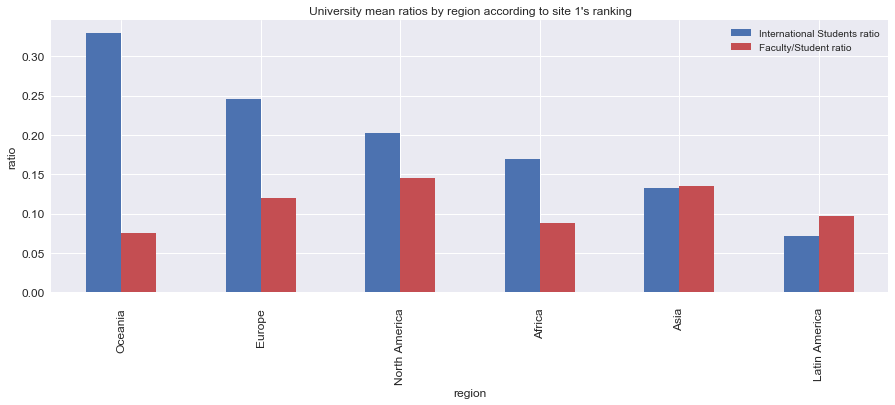

In [11]:
def plot(title, df, color, figsize=(15, 5), legend=None, **kwargs):
    f, ax = plt.subplots(figsize=figsize)
    df.plot(kind='bar', ax=ax, color=color, title=title, legend=True, fontsize=12, **kwargs)
    ax.set_xlabel(df.index.name, fontsize=12)
    ax.set_ylabel("ratio", fontsize=12)
    ax.set_xticklabels(df.index)
    ax.tick_params(axis='x', which='major', pad=15)
    if legend:
        ax.legend(legend)
    display(f)
    plt.close(f)

plot("University mean ratios by region according to site 1's ranking",
     uni_s1_regions.sort_values("pc_intl_students", ascending=False), color=['b','r'],
    legend=['International Students ratio', 'Faculty/Student ratio'])

From the plot above, we notice that the best region according to site 1 in terms of proportion of international students is Oceania, followed by Europe then North America. In terms of proportion of Faculty Members to Students the best region is North America followed by Asia and Europe. 


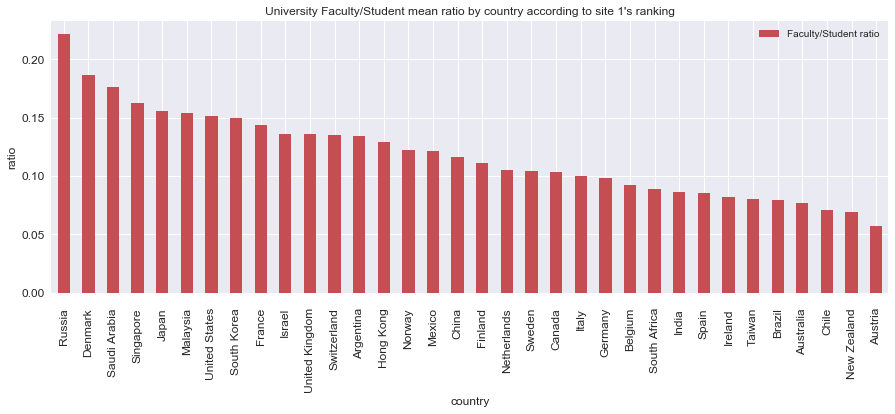

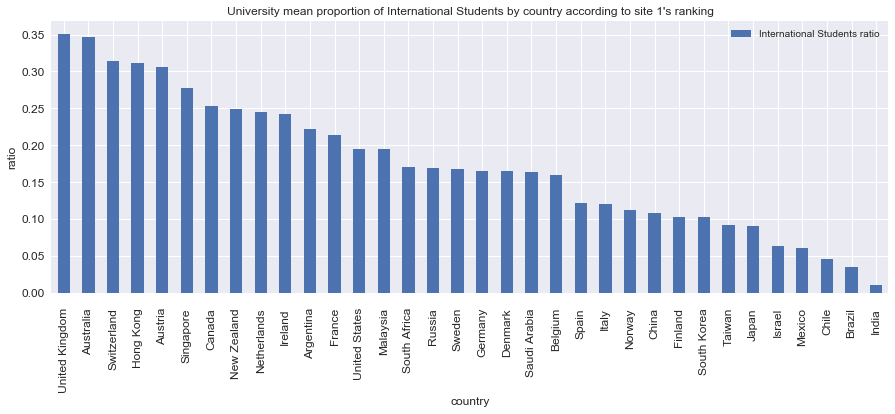

In [12]:
plot("University Faculty/Student mean ratio by country according to site 1's ranking",
     uni_s1_countries["staff_student_ratio"].sort_values(ascending=False), color=['r'], legend=['Faculty/Student ratio'])

plot("University mean proportion of International Students by country according to site 1's ranking",
     uni_s1_countries["pc_intl_students"].sort_values(ascending=False), color=['b'], legend=['International Students ratio'])

According to the rankings of the first website, the best countries are United Kingdom and Australia in terms of proportion of International students while the best are Russia and Denmark according to the Faculty Members to the number of Students ratio.

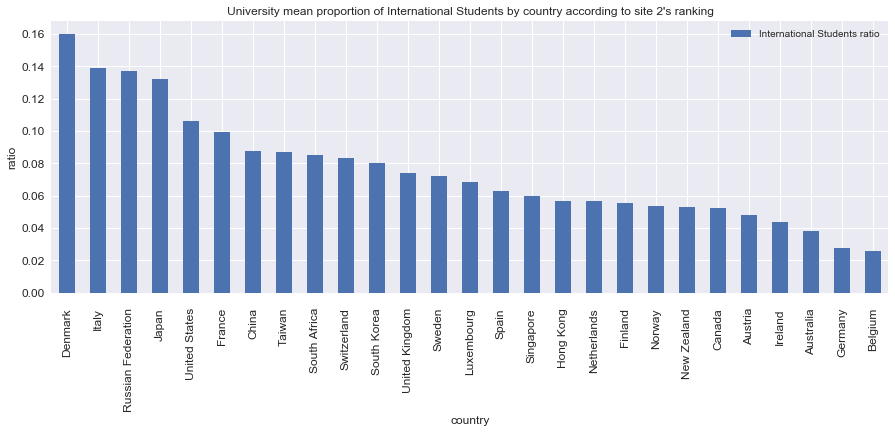

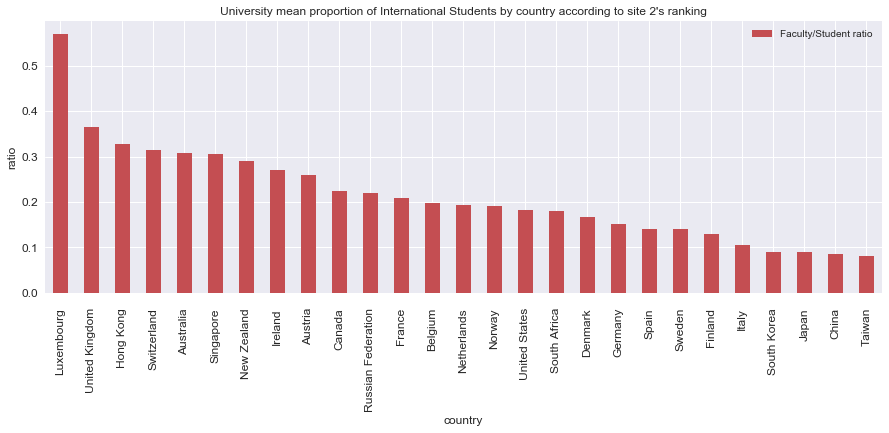

In [13]:
plot("University mean proportion of International Students by country according to site 2's ranking",
     uni_s2_countries["staff_student_ratio"].sort_values(ascending=False), color=['b'], legend=['International Students ratio'])

plot("University mean proportion of International Students by country according to site 2's ranking",
     uni_s2_countries["pc_intl_students"].sort_values(ascending=False), color=['r'], legend=['Faculty/Student ratio'])

According to the rankings of the second website, the best countries are Luxembourg and United Kingdom in terms of proportion of International students while the best are Denmark and Italy according to the Faculty Members to the number of Students ratio.

## Exploratory analysis


We have already observed that the two datasets have different statistics about the universities. We highlight this with some descriptive statistics:

In [14]:
uni_m['rank_diff'] = uni_m['rank']-uni_m['rank_2']
uni_m['intl_pc_diff'] = uni_m['pc_intl_students']-uni_m['pc_intl_students_2']
uni_m['staff_student_ratio_diff'] = uni_m['staff_student_ratio']-uni_m['staff_student_ratio_2']


uni_m[['name', 'rank_diff', 'intl_pc_diff', 'staff_student_ratio_diff']].head()

,name,rank_diff,intl_pc_diff,staff_student_ratio_diff
0,Massachusetts Institute of Technology (MIT),-4.0,-0.004137,0.154507
1,Stanford University,-1.0,0.007422,0.136537
2,Harvard University,-3.0,-0.025215,0.081586
3,California Institute of Technology (Caltech),1.0,0.016918,0.268770
4,University of Cambridge,3.0,0.006899,0.200745


We observe the distributions of the differences between the two websites datasets

In [15]:
def densplot(column):
    sns.distplot(column)
    plt.show()

def scatplot(xelem, yelem, xlabel, ylabel, title, polyfit=None):
    plt.scatter(xelem, yelem)
    if polyfit:
        plt.plot(np.unique(xelem), np.poly1d(np.polyfit(xelem, yelem, polyfit))(np.unique(xelem)), 'C2')
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()

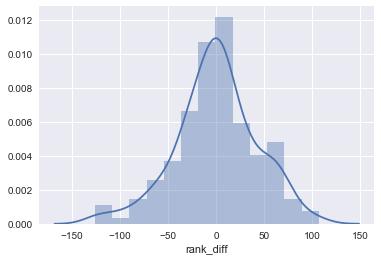

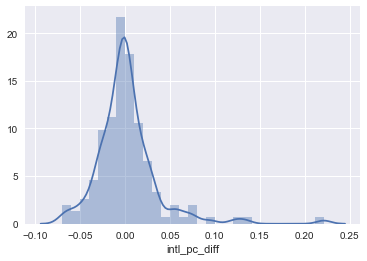

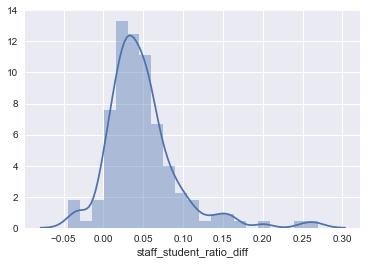

In [16]:
densplot(uni_m['rank_diff'])
densplot(uni_m['intl_pc_diff'])
densplot(uni_m['staff_student_ratio_diff'])

We observe that, while not being completely similar, the two datasets are consistent. This is because the distribution of the differences are mostly centered around zero. Nevertheless, we remark that the staff to student ratio difference is shifted by 0.05. This could imply that the two websites did not use the same assumptions when computing this statistic (for exemple, including or not PhD students in the staff). 

Now, we now look for correlations between different statistics. We **only** show the ones for which we found an interesting pattern.



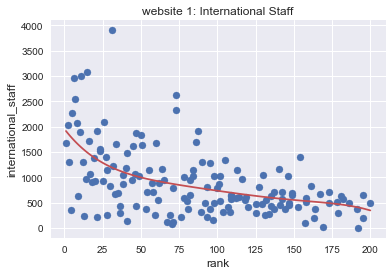

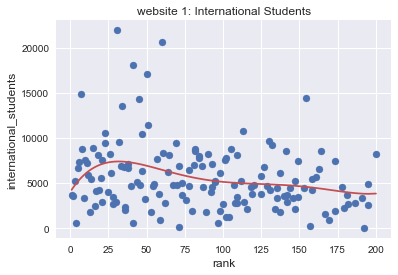

In [30]:
scatplot(uni_m['rank'], uni_m['fac_c_inter'], 'rank', 'international_staff', 'website 1: International Staff', 5)
scatplot(uni_m['rank'], uni_m['stu_c_inter'], 'rank', 'international_students', 'website 1: International Students', 5)

We observe that the number of international staff is important in website 1's computation of the rank. However, we notice that the number of international student does not matter so much. This is maybe a tendency to put research forward and education in second.

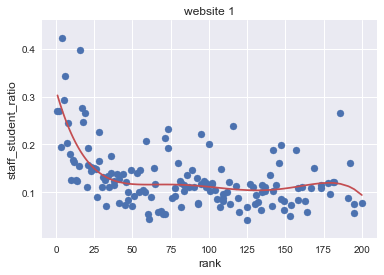

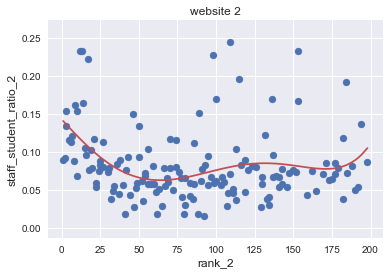

In [32]:
scatplot(uni_m['rank'], uni_m['staff_student_ratio'], 'rank', 'staff_student_ratio', 'website 1', 5)
scatplot(uni_m['rank_2'], uni_m['staff_student_ratio_2'], 'rank_2', 'staff_student_ratio_2', 'website 2', 5)

We observe that website 1 is giving more importance to the staff to student ratio in the computation of its rank than website 2. The higher the ratio, the better the rank.

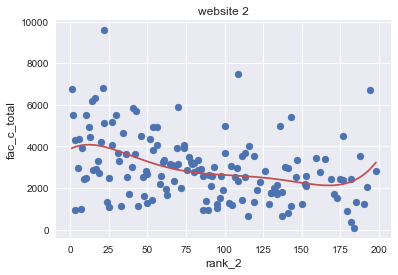

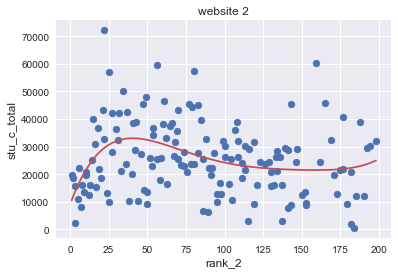

In [33]:
scatplot(uni_m['rank_2'], uni_m['fac_c_total'], 'rank_2', 'fac_c_total', 'website 2', 5)
scatplot(uni_m['rank_2'], uni_m['stu_c_total'], 'rank_2', 'stu_c_total', 'website 2', 5)

We observe in both website (but only show for the 2nd one) that the rank is barely correlated (positively) with the faculty size. The second plot shows that top universities tend to have less student. This shows that the staff to student ratio is indeed a very important metric to compute ranks.

### Rank combination

In order to select the best university according to both rankings, we simply average the rankings.
We just want to know the best university and there is no tie for the first one which is Stanford University.
In case of ties we would have broken these by putting first the university with the highest ranking. (Example: University of Cambridge (3) would be before Caltech (2) if we had to break the ties since it is ranked 2 in the second website).

In [34]:
uni_m['combine_rank'] = (uni_m['rank']+uni_m['rank_2'])/2

uni_ms = uni_m.sort_values(['combine_rank'])
uni_ms[["name", "combine_rank", "rank", "rank_2"]].reset_index(drop=True).head(4)

,name,combine_rank,rank,rank_2
0,Stanford University,2.5,2,3.0
1,Massachusetts Institute of Technology (MIT),3.0,1,5.0
2,California Institute of Technology (Caltech),3.5,4,3.0
3,University of Cambridge,3.5,5,2.0


We now relate the rank difference with both ranking, and show what are the implications on our combined ranking.

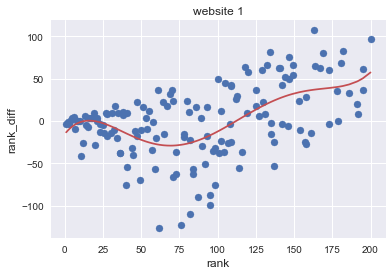

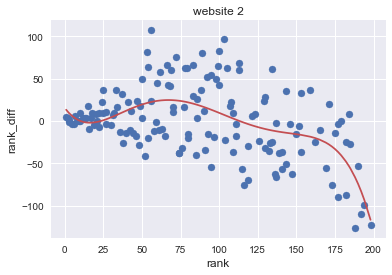

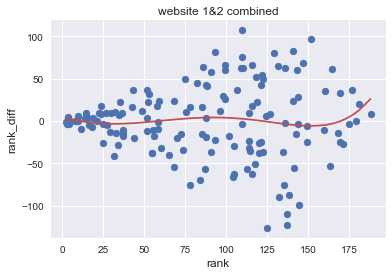

In [35]:
uni_m['diff_rank_abs'] = pd.DataFrame.abs(uni_m['rank']-uni_m['rank_2'])
uni_m['diff_rank'] = uni_m['rank']-uni_m['rank_2']

scatplot(uni_m['rank'], uni_m['diff_rank'], 'rank', 'rank_diff', 'website 1', 5)
scatplot(uni_m['rank_2'], uni_m['diff_rank'], 'rank', 'rank_diff', 'website 2', 5)
scatplot(uni_m['combine_rank'], uni_m['diff_rank'], 'rank', 'rank_diff', 'website 1&2 combined', 5)

We observe that the difference between the two rankings is smaller for high-ranked universities than for lower ranked universities. This could be because the ranking is done more precisely for the top-30 universities than for the others.

Moreover, we see an interesting pattern: for a given university in the intersection of both datasets, the second website has a tendency to rank it lower. Our combine rank mitigate this tendancy.